In [1]:
import sys
import os
import neo
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import seaborn as sns
import elephant as el
import quantities as pq
sns.set(style='ticks', palette='bright', context='talk')
sns.set_color_codes(palette='muted')

In [2]:
neo.__version__ # to 0.5b

'0.5.1'

## Load data with neo IO

In [3]:
filename = os.path.expanduser('~') + '/Sciebo/Data/WaveScalES/IDIBAPS/161101_rec07_Spontaneous_RH.smr'
neo_obj = neo.io.spike2io.Spike2IO(filename)

In [4]:
segment = neo_obj.read_segment()

## Annotate the analogsignals with metadata

In [5]:
electrode_location = {'Visual Cortex' : [18,19,20,22,23,24,25,27,28,29,30,31,32],
                      'Retrospenial Cortex' : [13,17,21,26],
                      'Parietal Association Cortex' : [14,15,16],
                      'Somatosensory Cortex' : [4,5,7,8,10,11,12],
                      'Motor Cortex' : [1,2,3,6,9]
                     }

electrode_color = {'Visual Cortex' : '#0C6BB1',
                   'Retrospenial Cortex' : '#422F58',
                   'Parietal Association Cortex' : '#01B24E',
                   'Somatosensory Cortex' : '#F92600',
                   'Motor Cortex' : '#EF6700'
                     }

for asig in segment.analogsignals:
    for element in electrode_location:
        if asig.annotations['physical_channel_index']+1 in electrode_location[element]:
            asig.annotations['cortical_location'] = element
            
# ToDo: Annotate with x and y position

## Plot signal traces

In [6]:
asig = segment.analogsignals[0] 
num_sampling_points = (asig.t_stop.rescale('s') - asig.t_start.rescale('s')) \
                    * asig.sampling_rate.rescale('1/s')
sampling_times = np.linspace(asig.t_start, asig.t_stop, num_sampling_points)

/home/rgutzen/anaconda3/envs/wavescale/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'quantities.quantity.Quantity'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


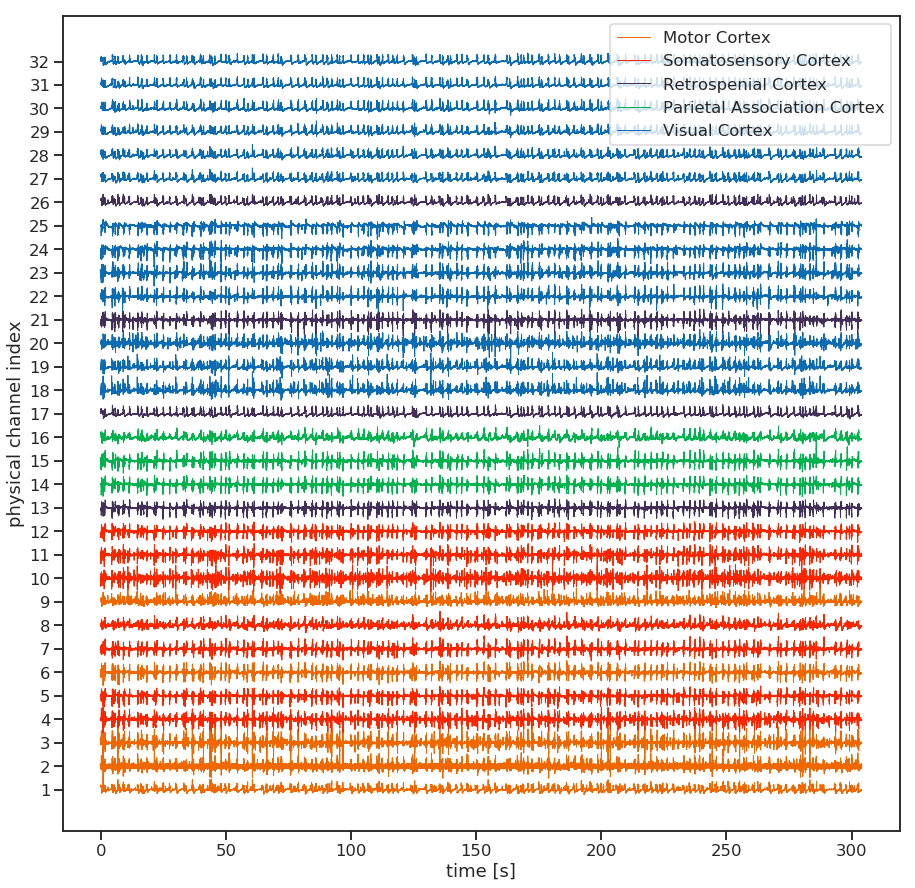

In [134]:
time_window = (0,304)  # in seconds [0,304]

fig, ax = plt.subplots(figsize=(15,15))
idx = [int(time_in_s * asig.sampling_rate.rescale('1/s').magnitude) for time_in_s in time_window]
scaling = 12
handles = {}
sorted_asigs = sorted(segment.analogsignals, key=lambda x: int(x.annotations['physical_channel_index']))
for asig_count, asig in enumerate(sorted_asigs):
    handle,  = ax.plot(sampling_times[idx[0]:idx[1]], 
               sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]) + asig_count*scaling,
               linewidth=1, color=electrode_color[asig.annotations['cortical_location']],
               label=asig.annotations['cortical_location'])
    handles[asig.annotations['cortical_location']] = handle
    
ax.set_yticks(np.arange(len(segment.analogsignals))*scaling)
ax.set_yticklabels([asig.annotations['physical_channel_index']+1 for asig in sorted_asigs])
ax.set_ylabel('physical channel index')
ax.set_xlabel('time [s]')
plt.legend([handle for handle in handles.values()], 
           [location for location in handles.keys()], loc=1)

## Filter signal (200 - 1500 Hz)

In [135]:
MUAFreqBand = (150, 1500)  # Hz
analogsignals_filtered = [el.signal_processing.butter(asig, highpass_freq=MUAFreqBand[0]*pq.Hz, lowpass_freq=MUAFreqBand[1]*pq.Hz, 
                         order=4, filter_function='filtfilt', fs=1.0, axis=-1) for asig in segment.analogsignals]

## Plot power spectrum

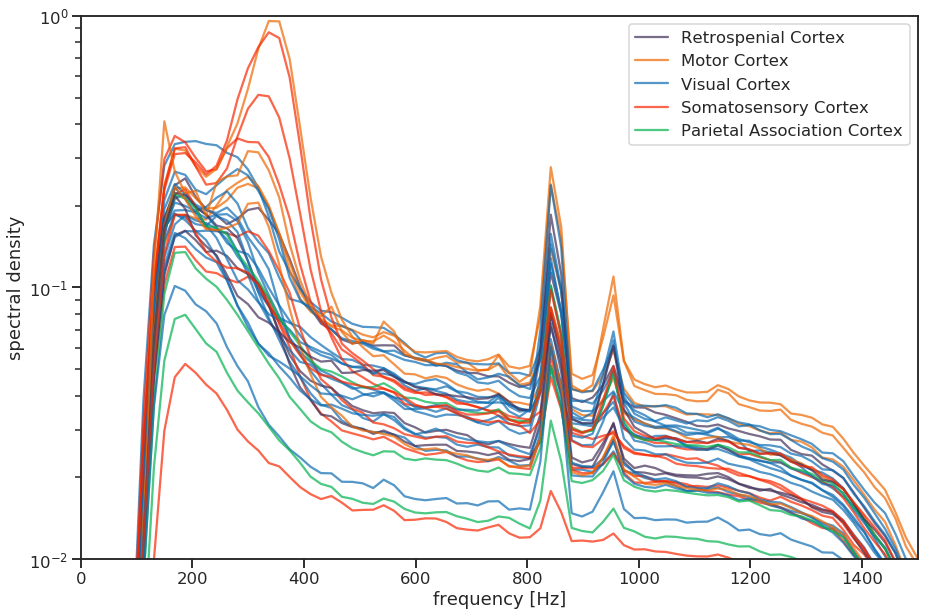

In [136]:
fig, ax = plt.subplots(figsize=(15,10))
handles = {}
for asig_count, asig in enumerate(analogsignals_filtered):
    (p1, f1) = psd(np.squeeze(asig.magnitude), NFFT=265, noverlap=50, 
                   Fs=asig.sampling_rate.rescale('Hz'))
    handle, = ax.semilogy(f1, p1, alpha=0.7, 
                          color=electrode_color[asig.annotations['cortical_location']])
    handles[asig.annotations['cortical_location']] = handle
ax.set_xlim((0,1500))
ax.set_ylim((10**(-2),10**(0)))
ax.set_ylabel('spectral density')
ax.set_xlabel('frequency [Hz]')
plt.legend([handle for handle in handles.values()], 
           [location for location in handles.keys()], loc=1)

## MUA estimation (for one channel)

In [142]:
channel_idx = 1
# asig = analogsignals_filtered[channel_idx]
asig = segment.analogsignals[channel_idx]


fs = asig.sampling_rate.rescale('1/s').magnitude
FFTWindowSize = int(round(fs / MUAFreqBand[0]))
sample_num = int(np.floor(len(asig)/FFTWindowSize))
print('FFTWindowSize', FFTWindowSize)
print('sample_num', sample_num)

def detrending(asig, order=2):
    X = asig.as_array()
    window_size = len(asig)
    if order > 0:
        X = X - np.mean(X, axis=0)
    if order > 1:
        factor = [1,1/2.,1/6.]
        for i in np.arange(order-1)+1:
            detrend = np.linspace(-window_size/2., window_size/2., window_size)**i \
                      * np.mean(np.diff(X, n=i, axis=0)) * factor[i-1]
            X = X - detrend
    return X

MUA = np.zeros(sample_num)

# calculating mean spectral power in each window
for i in range(sample_num):
    local_asig = asig[i*FFTWindowSize:(i+1)*FFTWindowSize]
    local_asig = detrending(local_asig, 1)
    (f,p) = el.spectral.welch_psd(np.squeeze(local_asig), num_seg=10, overlap=0.7, 
                          window='hanning', nfft=None, fs=fs,
                          detrend='constant', return_onesided=True, 
                          scaling='density', axis=-1)
    low_idx = np.where(MUAFreqBand[0] <= f)[0][0]
    high_idx = np.where(MUAFreqBand[1] <= f)[0][0]
    MUA[i] = np.mean(p[low_idx:high_idx])

# ToDo: Normalization with basline power?

FFTWindowSize 33
sample_num 45710


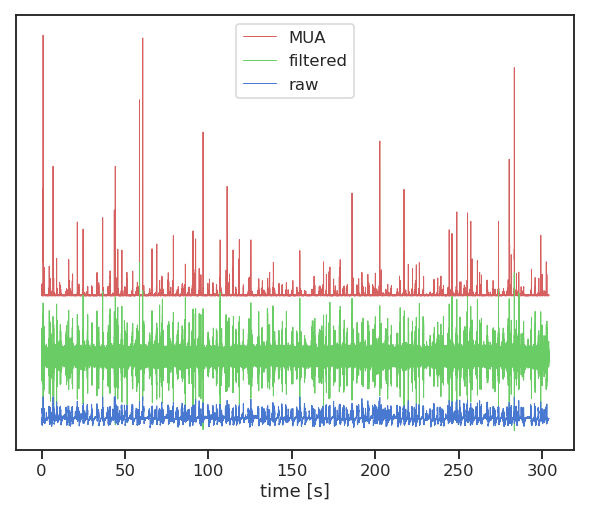

In [143]:
fig, ax = plt.subplots(figsize=(10,8))

asig = segment.analogsignals[channel_idx]
asig_filtered = analogsignals_filtered[channel_idx]
idx = [int(time_in_s * asig.sampling_rate.rescale('1/s').magnitude) 
       for time_in_s in time_window]
MUA_idx = [int(i/FFTWindowSize) for i in idx]

ax.plot(np.linspace(asig.t_start, asig.t_stop, sample_num)[MUA_idx[0]:MUA_idx[1]], 
        sc.stats.zscore(MUA)[MUA_idx[0]:MUA_idx[1]] + 30, 
        color='r', label='MUA', lw=1)
ax.plot(asig_filtered.times[idx[0]:idx[1]], 
        sc.stats.zscore(asig_filtered.magnitude[idx[0]:idx[1]]) + 15, 
        color='g', label='filtered', lw=1)
ax.plot(asig.times[idx[0]:idx[1]], 
        sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]), 
        color='b', label='raw', lw=1)
ax.set_xlabel('time [s]')
ax.set_yticks([])
plt.legend()

## Distribution of estimated signal amplitudes (log MUA)

Text(1.7656718281947108, -0.17590276171927915, 'UD threshold (4$\\sigma$)')

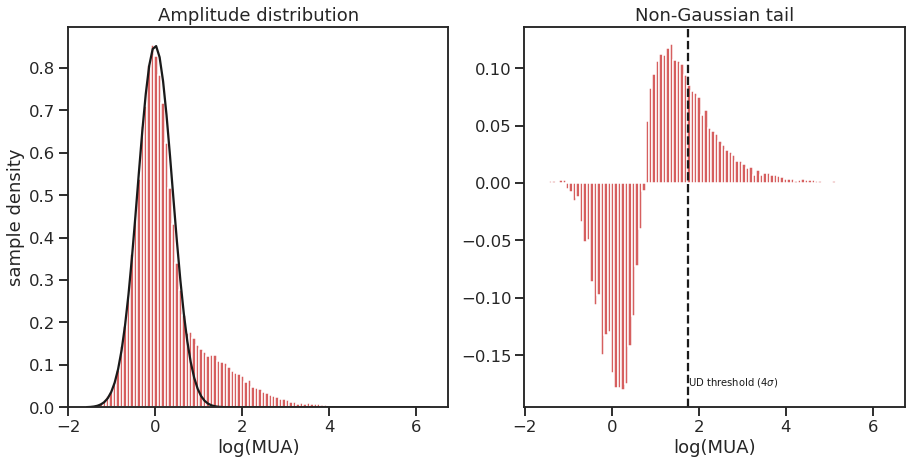

In [144]:
# signal amplitude distribution
hist, edges = np.histogram(np.log(MUA), bins=100, density=True)
xvalues = edges[:-1]+np.diff(edges)[0]/2.

# First Gaussian fit -> m0
gaussian = lambda x, m, s: 1./(s*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-m)/s)**2)
(m0, _), _ = sc.optimize.curve_fit(gaussian, xvalues, hist, p0=(-4,1))

# shifting to 0
xvalues -= m0

# Mirror left peak side for 2nd Gaussian fit -> s0
logMUA_leftpeak = np.log(MUA)[np.log(MUA) - m0 <= 0] - m0
logMUA_rightpeak = np.log(MUA)[np.log(MUA) - m0 > 0] - m0
left_right_ratio = len(logMUA_leftpeak) * 2./len(MUA)
logMUA_peak = np.append(logMUA_leftpeak, -1*logMUA_leftpeak)
peakhist, edges = np.histogram(logMUA_peak, bins=100, density=True)
xvalues2 = edges[:-1]+np.diff(edges)[0]/2.

# Second Gaussian fit
(_, s0), _ = sc.optimize.curve_fit(gaussian, xvalues2, peakhist, p0=(0,1))

# UD threshold
UDth = 4*s0

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].bar(xvalues, hist, width=np.diff(xvalues)[0], color='r')
ax[0].plot(xvalues, [left_right_ratio * gaussian(x, 0, s0) for x in xvalues], c='k')
ax[0].set_xlabel('log(MUA)')
ax[0].set_ylabel('sample density')
ax[0].set_title('Amplitude distribution')

ax[1].bar(xvalues, [hist[i]-gaussian(x,0,s0) for (i,x) in enumerate(xvalues)],
          width=np.diff(xvalues)[0], color='r')
ax[1].set_xlabel('log(MUA)')
ax[1].set_title('Non-Gaussian tail')
ax[1].axvline(1.1*UDth, color='k', ls='--'), 
ax[1].text(1.1*UDth, 0.9*ax[1].get_ylim()[0], 
           r'UD threshold ({}$\sigma$)'.format(int(round(UDth/s0))), color='k')

minimum state duration =  0.0133060057669168 s


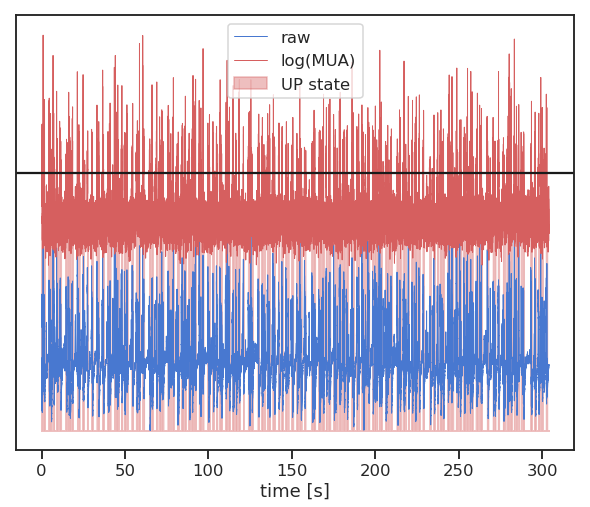

In [145]:
fig, ax = plt.subplots(figsize=(10,8))

up = np.max(sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]))
down = np.min(sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]))

state_vector = [True if np.log(mua)-m0 > UDth else False for mua in MUA[MUA_idx[0]:MUA_idx[1]]]

min_state_duration = 2 # bins of MUA sampling rate
print('minimum state duration = ', 
      np.diff(np.linspace(asig.t_start, asig.t_stop, sample_num))[0] * min_state_duration)

# remove states shorter than min_state_duration
for (i, bin_state) in enumerate(state_vector[:-min_state_duration-1]):
    if bin_state != state_vector[i+1] and bin_state == state_vector[i+1+min_state_duration]:
        state_vector[i:i+1+min_state_duration] = [bin_state] * (min_state_duration+1)
    else:
        pass        

UD_state = [up if state else down for state in state_vector]

ax.plot(asig.times[idx[0]:idx[1]], 
        sc.stats.zscore(asig.magnitude[idx[0]:idx[1]]), 
        color='b', label='raw', lw=1)

# ax.plot(np.linspace(asig.t_start, asig.t_stop, sample_num)[MUA_idx[0]:MUA_idx[1]], 
#         UD_state, color='r', lw=1, label='UD state')          

ax.fill_between(np.linspace(asig.t_start, asig.t_stop, sample_num)[MUA_idx[0]:MUA_idx[1]], 
                [down for _ in UD_state], UD_state, 
                color='r', alpha=0.4, label='UP state')  

ax.plot(np.linspace(asig.t_start, asig.t_stop, sample_num)[MUA_idx[0]:MUA_idx[1]], 
        np.log(MUA[MUA_idx[0]:MUA_idx[1]])-m0 + 5, 
        color='r', label='log(MUA)', lw=1)

ax.axhline(UDth+5, color='k')

ax.set_xlabel('time [s]')
ax.set_yticks([])
plt.legend()
# ax.set_xlim((280,282));

In [146]:
# critical paramets: frequency range, threshold, (see new paper draft), fixing threshold to absolute value across channels (alternative fixing to sigma, i.e. fixing the false positive rate)
# duration of up-states, min state duration = 80ms, faster fluctuations are ignored

In [147]:
# increase window size? smooth log(MUA)? no prior filtering (reduces amplitudes)?

## Estimate average up and down slopes

Text(0.5, 1.0, 'Down transition')

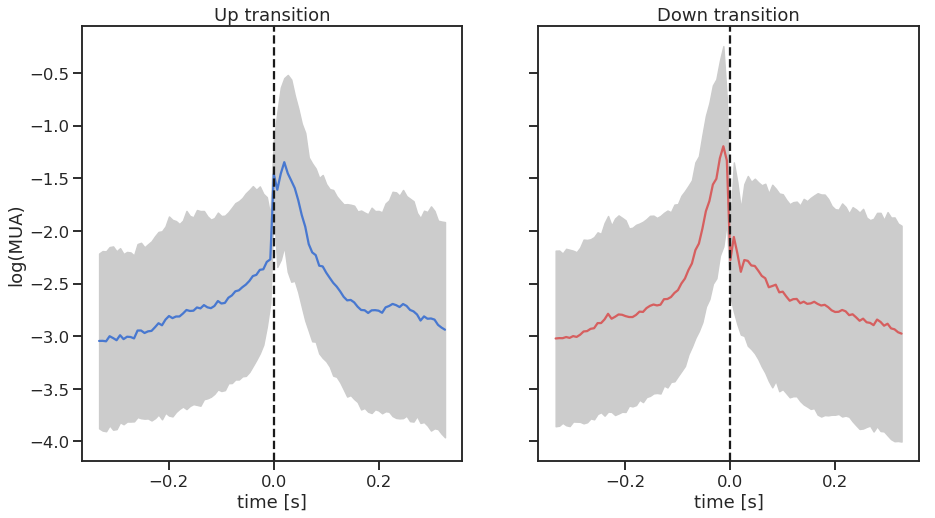

In [148]:
# in matlab: estimation of average transition slope with qubic interpolation on average -> slope estimate
slope_window = 50  # in bins of MUA sampling rate
logMUA = np.log(MUA[MUA_idx[0]:MUA_idx[1]])
MUA_time_res = np.diff(np.linspace(asig.t_start, asig.t_stop, sample_num))[0]

up_transitions = []
down_transitions = []



for (i, bin_state) in enumerate(state_vector):
    if state_vector[i-1] != bin_state and i > slope_window and i < len(state_vector)-slope_window:
        if bin_state and logMUA[i-slope_window:i+slope_window].any():
            up_transitions += [logMUA[i-slope_window:i+slope_window]]
#             ax.plot(np.arange(2*slope_window)-slope_window, up_transitions[-1])
        elif logMUA[i-slope_window:i+slope_window].any():
            down_transitions += [logMUA[i-slope_window:i+slope_window]]
    else:
        pass
avg_up_slope = np.mean(up_transitions, axis=0)
avg_down_slope = np.mean(down_transitions, axis=0)


fig, ax = plt.subplots(ncols=2, figsize=(15,8), sharey=True)

ax[0].plot((np.arange(2*slope_window)-slope_window)*MUA_time_res, avg_up_slope, color='b')
ax[0].fill_between((np.arange(2*slope_window)-slope_window)*MUA_time_res, 
                avg_up_slope - np.std(up_transitions, axis=0),
                avg_up_slope + np.std(up_transitions, axis=0), color='0.8')
ax[0].axvline(0, ls='--', color='k')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('log(MUA)')
ax[0].set_title('Up transition')

ax[1].plot((np.arange(2*slope_window)-slope_window)*MUA_time_res, avg_down_slope, color='r')
ax[1].fill_between((np.arange(2*slope_window)-slope_window)*MUA_time_res, 
                avg_down_slope - np.std(down_transitions, axis=0),
                avg_down_slope + np.std(down_transitions, axis=0), color='0.8')
ax[1].axvline(0, ls='--', color='k')
ax[1].set_xlabel('time [s]')
ax[1].set_title('Down transition')

In [149]:
# Next steps: detect wave fronts and visualize moving waves in space, statistics of UD states

In [150]:
# include general function into Elephant, i.e. detrending, state_detection, 